In [48]:
import requests
import pandas as pd
import requests
import functools
from bs4 import BeautifulSoup
import collections
import string
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

class Wayback:
    def __init__(self, search_url, grouping=8):
        self.search_url = search_url
        self.snapshots = None
        self.session = requests.Session()
        self.grouping = grouping
    
    @functools.lru_cache(maxsize=100)
    def get(self, url):
        return self.session.get(url)
    
    def fetch_snapshots(self):
        res = self.session.get(f"https://web.archive.org/cdx/search/cdx?url={self.search_url}&output=json&collapse=timestamp:{self.grouping}").json()
        dt = pd.DataFrame(res[1:], columns=res[0])
        dt.loc[:, "ts"] = pd.to_datetime(dt.timestamp, format="%Y%m%d%H%M%S")
        dt = dt.set_index("ts").sort_index()
        dt = dt[dt.statuscode == "200"]
        display(dt)
        return dt
    
    def fetch_page(self, main_item):
        if isinstance(main_item, tuple):
            main_item = main_item[1]    
            
        res = self.get(f"https://web.archive.org/web/{main_item.timestamp}id_/{main_item.original}")
        parser = BeautifulSoup(res.content, "html.parser")
        items = [i.getText() for i in parser.find_all("h3")]
        items = [i for i in items if i.strip()]
        losses = {"Russia": collections.defaultdict(lambda: collections.defaultdict(dict)), "Ukraine": collections.defaultdict(lambda: collections.defaultdict(dict))}
        key = None
        for item in items:
            if item in losses:
                key = item
                continue
                
            for k in losses:
                found = False
                if k in item:
                    key = k
                    found = True
                    break
                    
            if found:
                print(main_item.name, item)
                continue
            
            pts = item.split("(")
            veh_type = "(".join(pts[:-1]).strip().lower()
            for s in string.punctuation + string.whitespace:
                veh_type = veh_type.replace(s, "")
            detail = pts[-1].split(")")[0].strip().split(",")
            for d in detail:
                if all(c in string.digits for c in d):
                    continue
                if ":" in d:
                    n = int(d.split(":")[-1].strip())
                elif " " in d:
                    n = int(d.split(" ")[-1].strip())
                else:
                    raise ValueError(item)
                if "damaged" in d:
                    losses[key][veh_type]["damaged"] = n
                if "captured" in d:
                    losses[key][veh_type]["captured"] = n
                if "destroyed" in d:
                    losses[key][veh_type]["destroyed"] = n
                if "abandon" in d:
                    losses[key][veh_type]["abandoned"] = n
        losses["time"] = main_item.name
        return losses
    
    def fetch_parallel(self, items):
        with ThreadPoolExecutor(5) as tpe:
            futures = [tpe.submit(self.fetch_page, i) for i in items.iterrows()]
            res = list(tqdm(as_completed(futures), total=len(futures)))
        df = pd.json_normalize([r.result() for r in res]).set_index("time")
        df.columns = df.columns.map(lambda s: tuple(s.split(".")))
        return df.astype(float).sort_index(axis=0).sort_index(axis=1)
        
w = Wayback("https://www.oryxspioenkop.com/2022/02/attack-on-europe-documenting-equipment.html", 8)
snaps = w.fetch_snapshots() 

w2 = Wayback("https://www.oryxspioenkop.com/2022/02/attack-on-europe-documenting-ukrainian.html", 8)
snaps2 = w2.fetch_snapshots()

,urlkey,timestamp,original,mimetype,statuscode,digest,length
ts,,,,,,,
2022-02-24 12:35:34,"com,oryxspioenkop)/2022/02/attack-on-europe-do...",20220224123534,https://www.oryxspioenkop.com/2022/02/attack-o...,text/html,200,7IMGQE7YNTCZYW7M4DKF7JIPKETOGAEM,53089
2022-02-26 16:31:27,"com,oryxspioenkop)/2022/02/attack-on-europe-do...",20220226163127,https://www.oryxspioenkop.com/2022/02/attack-o...,text/html,200,JM47VTY26UVDDUG3EJUBWMPUPKKDUBAZ,72608
2022-02-27 02:37:09,"com,oryxspioenkop)/2022/02/attack-on-europe-do...",20220227023709,https://www.oryxspioenkop.com/2022/02/attack-o...,text/html,200,S5UR65ZFR4CRX5FQRMQ5TLMMTILU22LT,75573
2022-02-28 00:57:24,"com,oryxspioenkop)/2022/02/attack-on-europe-do...",20220228005724,https://www.oryxspioenkop.com/2022/02/attack-o...,text/html,200,RLNR34U4MTAEIBYUTULDK7VYU3LE73Y6,86129
2022-03-01 00:53:36,"com,oryxspioenkop)/2022/02/attack-on-europe-do...",20220301005336,https://www.oryxspioenkop.com/2022/02/attack-o...,text/html,200,LGCEZKTMCYVKVTLNYI6E2BQ4Z56Y2WH4,93751
2022-03-02 06:53:31,"com,oryxspioenkop)/2022/02/attack-on-europe-do...",20220302065331,https://www.oryxspioenkop.com/2022/02/attack-o...,text/html,200,L5KUTHG53WWVGWUJJCC7LCN66WOJ3T5Q,96320
2022-03-03 00:28:12,"com,oryxspioenkop)/2022/02/attack-on-europe-do...",20220303002812,https://www.oryxspioenkop.com/2022/02/attack-o...,text/html,200,QRQ5ND4MHX5I3UXWY2D6IROZIVGV6JAP,98397
2022-03-04 01:36:58,"com,oryxspioenkop)/2022/02/attack-on-europe-do...",20220304013658,https://www.oryxspioenkop.com/2022/02/attack-o...,text/html,200,ZH43WU3IT3YWBH3DBG6VLY5XQ252GJZU,65524
2022-03-05 01:06:40,"com,oryxspioenkop)/2022/02/attack-on-europe-do...",20220305010640,https://www.oryxspioenkop.com/2022/02/attack-o...,text/html,200,ET7T2TJK6TEQVZUXNXHLJZKY5FRSNCFL,75123


,urlkey,timestamp,original,mimetype,statuscode,digest,length
ts,,,,,,,
2022-04-20 17:13:13,"com,oryxspioenkop)/2022/02/attack-on-europe-do...",20220420171313,https://www.oryxspioenkop.com/2022/02/attack-o...,text/html,200,6KRQFDV2RS64EOMXPDFLYN5CXWZNNYY3,60591
2022-04-21 20:24:44,"com,oryxspioenkop)/2022/02/attack-on-europe-do...",20220421202444,https://www.oryxspioenkop.com/2022/02/attack-o...,text/html,200,4RW77PUXHUQ2WV5U4ANNSVPGV4LS4TFO,68703
2022-04-22 01:51:08,"com,oryxspioenkop)/2022/02/attack-on-europe-do...",20220422015108,https://www.oryxspioenkop.com/2022/02/attack-o...,text/html,200,YCEAO34FIGJDOJ5UL3ZMT2H3BPUGDNB4,68429
2022-04-23 01:23:56,"com,oryxspioenkop)/2022/02/attack-on-europe-do...",20220423012356,https://www.oryxspioenkop.com/2022/02/attack-o...,text/html,200,L4QNAVCY3RTN6MW6GH2WTFIWWGDYIVGF,66474


In [49]:
data = w2.fetch_parallel(snaps.append(snaps2))

  3%|██▋                                                                                | 2/62 [00:01<00:39,  1.52it/s]

2022-03-01 00:53:36 Russia - 327, of which: destroyed: 143, damaged: 7, abandoned: 72, captured: 103
2022-03-01 00:53:36 Ukraine - 149, of which: destroyed: 53, damaged: 4, abandoned: 38, captured: 52


  8%|██████▋                                                                            | 5/62 [00:01<00:23,  2.38it/s]

2022-02-27 02:37:09 Russia - 107, of which: destroyed: 42, damaged: 6, abandoned: 10, captured: 49
2022-02-27 02:37:09 Ukraine - 90, of which: destroyed: 36, damaged: 4, abandoned: 31, captured: 17
2022-02-26 16:31:27 Russia - 106, of which: destroyed: 41, damaged: 6, abandoned: 10, captured: 49
2022-02-26 16:31:27 Ukraine - 87, of which: destroyed: 33, damaged: 4, abandoned: 31, captured: 17
2022-02-28 00:57:24 Russia - 213, of which: destroyed: 102, damaged: 6, abandoned: 33, captured: 72
2022-02-28 00:57:24 Ukraine - 115, of which: destroyed: 45, damaged: 4, abandoned: 35, captured: 29


 10%|████████                                                                           | 6/62 [00:02<00:24,  2.32it/s]

2022-03-02 06:53:31 Russia - 423, of which: destroyed: 177, damaged: 8, abandoned: 107, captured: 131
2022-03-02 06:53:31 Ukraine - 156, of which: destroyed: 56, damaged: 4, abandoned: 41, captured: 53


 13%|██████████▋                                                                        | 8/62 [00:02<00:16,  3.21it/s]

2022-03-03 00:28:12 Russia - 497, of which: destroyed: 202, damaged: 7, abandoned: 126, captured: 163
2022-03-03 00:28:12 Ukraine - 172, of which: destroyed: 67, damaged: 4, abandoned: 43, captured: 56
2022-03-04 01:36:58 Russia - 580, of which: destroyed: 234, damaged: 8, abandoned: 137, captured: 201
2022-03-04 01:36:58 Ukraine - 183, of which: destroyed: 71, damaged: 4, abandoned: 43, captured: 65


 15%|████████████                                                                       | 9/62 [00:03<00:17,  3.06it/s]

2022-03-05 01:06:40 Russia - 631, of which: destroyed: 250, damaged: 9, abandoned: 140, captured: 231
2022-03-05 01:06:40 Ukraine - 204, of which: destroyed: 80, damaged: 4, abandoned: 44, captured: 76


 16%|█████████████▏                                                                    | 10/62 [00:03<00:18,  2.84it/s]

2022-03-06 05:49:38 Russia - 730, of which: destroyed: 287, damaged: 10, abandoned: 143, captured: 290
2022-03-06 05:49:38 Ukraine - 234, of which: destroyed: 88, damaged: 4, abandoned: 44, captured: 98


 18%|██████████████▌                                                                   | 11/62 [00:03<00:16,  3.18it/s]

2022-03-07 01:17:41 Russia - 845, of which: destroyed: 337, damaged: 10, abandoned: 147, captured: 351
2022-03-07 01:17:41 Ukraine - 248, of which: destroyed: 93, damaged: 4, abandoned: 44, captured: 105


 19%|███████████████▊                                                                  | 12/62 [00:04<00:18,  2.64it/s]

2022-03-09 00:29:11 Russia - 949, of which: destroyed: 378, damaged: 13, abandoned: 157, captured: 399
2022-03-09 00:29:11 Ukraine - 275, of which: destroyed: 96, damaged: 5, abandoned: 44, captured: 127


 23%|██████████████████▌                                                               | 14/62 [00:04<00:15,  3.18it/s]

2022-03-10 03:00:42 Russia - 969, of which: destroyed: 386, damaged: 13, abandoned: 158, captured: 412
2022-03-10 03:00:42 Ukraine - 274, of which: destroyed: 96, damaged: 5, abandoned: 43, captured: 130
2022-03-08 00:58:46 Russia - 902, of which: destroyed: 358, damaged: 10, abandoned: 150, captured: 382
2022-03-08 00:58:46 Ukraine - 272, of which: destroyed: 94, damaged: 4, abandoned: 44, captured: 127


 24%|███████████████████▊                                                              | 15/62 [00:05<00:15,  3.02it/s]

2022-03-12 00:23:42 Russia - 1110, of which: destroyed: 458, damaged: 14, abandoned: 171, captured: 467
2022-03-12 00:23:42 Ukraine - 303, of which: destroyed: 115, damaged: 5, abandoned: 45, captured: 138


 26%|█████████████████████▏                                                            | 16/62 [00:05<00:14,  3.13it/s]

2022-03-11 00:39:45 Russia - 1034, of which: destroyed: 424, damaged: 13, abandoned: 159, captured: 438
2022-03-11 00:39:45 Ukraine - 284, of which: destroyed: 107, damaged: 5, abandoned: 43, captured: 129


 27%|██████████████████████▍                                                           | 17/62 [00:06<00:22,  2.02it/s]

2022-03-13 00:07:22 Russia - 1136, of which: destroyed: 474, damaged: 14, abandoned: 172, captured: 476
2022-03-13 00:07:22 Ukraine - 318, of which: destroyed: 120, damaged: 5, abandoned: 45, captured: 148


 29%|███████████████████████▊                                                          | 18/62 [00:07<00:22,  1.94it/s]

2022-03-15 00:07:09 Russia - 1292, of which: destroyed: 550, damaged: 19, abandoned: 203, captured: 520
2022-03-15 00:07:09 Ukraine - 343, of which: destroyed: 132, damaged: 5, abandoned: 47, captured: 159
2022-03-14 01:04:28 Russia - 1234, of which: destroyed: 525, damaged: 15, abandoned: 193, captured: 501
2022-03-14 01:04:28 Ukraine - 333, of which: destroyed: 129, damaged: 5, abandoned: 45, captured: 154


 32%|██████████████████████████▍                                                       | 20/62 [00:07<00:17,  2.44it/s]

2022-03-16 02:04:08 Russia - 1349, of which: destroyed: 581, damaged: 24, abandoned: 209, captured: 535
2022-03-16 02:04:08 Ukraine - 360, of which: destroyed: 135, damaged: 5, abandoned: 47, captured: 173


 34%|███████████████████████████▊                                                      | 21/62 [00:07<00:15,  2.57it/s]

2022-03-17 04:54:06 Russia - 1380, of which: destroyed: 598, damaged: 20, abandoned: 211, captured: 551
2022-03-17 04:54:06 Ukraine - 362, of which: destroyed: 135, damaged: 5, abandoned: 48, captured: 174


 35%|█████████████████████████████                                                     | 22/62 [00:08<00:14,  2.82it/s]

2022-03-18 00:22:35 Russia - 1506, of which: destroyed: 698, damaged: 24, abandoned: 220, captured: 563
2022-03-18 00:22:35 Ukraine - 373, of which: destroyed: 143, damaged: 5, abandoned: 48, captured: 177


 37%|██████████████████████████████▍                                                   | 23/62 [00:08<00:14,  2.71it/s]

2022-03-20 03:07:49 Russia - 1610, of which: destroyed: 769, damaged: 30, abandoned: 224, captured: 587
2022-03-20 03:07:49 Ukraine - 388, of which: destroyed: 153, damaged: 5, abandoned: 49, captured: 181
2022-03-21 03:50:43

 39%|███████████████████████████████▋                                                  | 24/62 [00:08<00:12,  3.03it/s]

 Russia - 1660, of which: destroyed: 799, damaged: 30, abandoned: 222, captured: 609
2022-03-21 03:50:43 Ukraine - 397, of which: destroyed: 160, damaged: 5, abandoned: 49, captured: 183


 40%|█████████████████████████████████                                                 | 25/62 [00:08<00:11,  3.16it/s]

2022-03-19 02:30:38 Russia - 1542, of which: destroyed: 712, damaged: 27, abandoned: 223, captured: 579
2022-03-19 02:30:38 Ukraine - 388, of which: destroyed: 153, damaged: 5, abandoned: 49, captured: 181


 42%|██████████████████████████████████▍                                               | 26/62 [00:09<00:12,  2.82it/s]

2022-03-22 01:21:33 Russia - 1663, of which: destroyed: 800, damaged: 31, abandoned: 221, captured: 611
2022-03-22 01:21:33 Ukraine - 500, of which: destroyed: 185, damaged: 10, abandoned: 37, captured: 268


 44%|███████████████████████████████████▋                                              | 27/62 [00:10<00:17,  2.05it/s]

2022-03-25 03:45:18 Russia - 1794, of which: destroyed: 877, damaged: 34, abandoned: 228, captured: 655
2022-03-25 03:45:18 Ukraine - 536, of which: destroyed: 205, damaged: 16, abandoned: 37, captured: 278
2022-03-23 07:38:52 Russia - 1706, of which: destroyed: 827, damaged: 32, abandoned: 221, captured: 626
2022-03-23 07:38:52 Ukraine - 505, of which: destroyed: 186, damaged: 11, abandoned: 37, captured: 271


 47%|██████████████████████████████████████▎                                           | 29/62 [00:10<00:14,  2.32it/s]

2022-03-26 01:05:30 Russia - 1878, of which: destroyed: 930, damaged: 35, abandoned: 228, captured: 685
2022-03-26 01:05:30 Ukraine - 540, of which: destroyed: 206, damaged: 16, abandoned: 37, captured: 281


 48%|███████████████████████████████████████▋                                          | 30/62 [00:11<00:16,  1.99it/s]

2022-03-27 06:09:40 Russia - 1924, of which: destroyed: 959, damaged: 35, abandoned: 232, captured: 698
2022-03-27 06:09:40 2022-03-24 05:27:17 Russia - 1782, of which: destroyed: 869, damaged: 33, abandoned: 228, captured: 652
2022-03-24 05:27:17 Ukraine - 520, of which: destroyed: 196, damaged: 12, abandoned: 37, captured: 275
Ukraine - 558, of which: destroyed: 209, damaged: 16, abandoned: 37, captured: 296


 52%|██████████████████████████████████████████▎                                       | 32/62 [00:12<00:15,  1.90it/s]

2022-03-29 07:01:16 Russia - 2019, of which: destroyed: 1004, damaged: 38, abandoned: 232, captured: 745
2022-03-29 07:01:16 Ukraine - 574, of which: destroyed: 225, damaged: 16, abandoned: 37, captured: 296
2022-03-30 00:08:36 Russia - 2085, of which: destroyed: 1041, damaged: 38, abandoned: 235, captured: 771

 53%|███████████████████████████████████████████▋                                      | 33/62 [00:12<00:12,  2.35it/s]


2022-03-30 00:08:36 Ukraine - 578, of which: destroyed: 229, damaged: 16, abandoned: 37, captured: 296
2022-03-28 02:36:34 Russia - 1986, of which: destroyed: 985, damaged: 37, abandoned: 232, captured: 732
2022-03-28 02:36:34 Ukraine - 574, of which: destroyed: 225, damaged: 16, abandoned: 37, captured: 296


 56%|██████████████████████████████████████████████▎                                   | 35/62 [00:13<00:11,  2.34it/s]

2022-04-01 00:27:24 Russia - 2147, of which: destroyed: 1085, damaged: 41, abandoned: 234, captured: 787
2022-04-01 00:27:24 Ukraine - 656, of which: destroyed: 283, damaged: 18, abandoned: 37, captured: 318
2022-03-31 02:27:47 Russia - 2111, of which: destroyed: 1061, damaged: 41, abandoned: 233, captured: 776
2022-03-31 02:27:47 Ukraine - 624, of which: destroyed: 262, damaged: 17, abandoned: 37, captured: 308


 60%|████████████████████████████████████████████████▉                                 | 37/62 [00:14<00:09,  2.73it/s]

2022-04-03 00:37:14 Russia - 2286, of which: destroyed: 1158, damaged: 41, abandoned: 234, captured: 853
2022-04-03 00:37:14 Ukraine - 660, of which: destroyed: 286, damaged: 18, abandoned: 37, captured: 319


 61%|██████████████████████████████████████████████████▎                               | 38/62 [00:14<00:10,  2.23it/s]

2022-04-02 00:13:13 Russia - 2278, of which: destroyed: 1155, damaged: 41, abandoned: 233, captured: 849
2022-04-02 00:13:13 Ukraine - 659, of which: destroyed: 285, damaged: 18, abandoned: 37, captured: 319


 63%|███████████████████████████████████████████████████▌                              | 39/62 [00:15<00:11,  1.93it/s]

2022-04-04 02:24:03 Russia - 2394, of which: destroyed: 1207, damaged: 41, abandoned: 232, captured: 913
2022-04-04 02:24:03 2022-04-05 03:50:45 Russia - 2437, of which: destroyed: 1235, damaged: 39, abandoned: 236, captured: 927
2022-04-05 03:50:45 Ukraine - 680, of which: destroyed: 300, damaged: 20, abandoned: 37, captured: 323
Ukraine - 674, of which: destroyed: 296, damaged: 19, abandoned: 37, captured: 322


 66%|██████████████████████████████████████████████████████▏                           | 41/62 [00:15<00:07,  2.63it/s]

2022-04-06 01:44:28 Russia - 2491, of which: destroyed: 1270, damaged: 38, abandoned: 238, captured: 945
2022-04-06 01:44:28 Ukraine - 684, of which: destroyed: 303, damaged: 20, abandoned: 37, captured: 324


 68%|███████████████████████████████████████████████████████▌                          | 42/62 [00:16<00:11,  1.70it/s]

2022-04-08 04:34:23 Russia - 2608, of which: destroyed: 1351, damaged: 38, abandoned: 237, captured: 982
2022-04-08 04:34:23 Ukraine - 697, of which: destroyed: 311, damaged: 24, abandoned: 37, captured: 325


 69%|████████████████████████████████████████████████████████▊                         | 43/62 [00:16<00:09,  2.02it/s]

2022-04-07 01:53:37 Russia - 2572, of which: destroyed: 1322, damaged: 38, abandoned: 238, captured: 974
2022-04-07 01:53:37 Ukraine - 689, of which: destroyed: 305, damaged: 21, abandoned: 37, captured: 326


 71%|██████████████████████████████████████████████████████████▏                       | 44/62 [00:17<00:10,  1.71it/s]

2022-04-11 03:50:14 2022-04-09 06:03:48 Russia - 2746, of which: destroyed: 1443, damaged: 39, abandoned: 233, captured: 1031
2022-04-11 03:50:14 Ukraine - 728, of which: destroyed: 333, damaged: 24, abandoned: 37, captured: 334
Russia - 2616, of which: destroyed: 1358, damaged: 38, abandoned: 237, captured: 983
2022-04-09 06:03:48 Ukraine - 701, of which: destroyed: 311, damaged: 24, abandoned: 37, captured: 329
2022-04-13 03:39:52 Russia - 2799, of which: destroyed: 1472, damaged: 39, abandoned: 234, captured: 1054
2022-04-13 03:39:52 Ukraine - 757, of which: destroyed: 345, damaged: 23, abandoned: 35, captured: 354

 74%|████████████████████████████████████████████████████████████▊                     | 46/62 [00:18<00:08,  1.84it/s]

2022-04-10 00:51:19 Russia - 2702, of which: destroyed: 1419, damaged: 39, abandoned: 236, captured: 1008
2022-04-10 00:51:19 Ukraine - 717, of which: destroyed: 323, damaged: 24, abandoned: 37, captured: 333



 76%|██████████████████████████████████████████████████████████████▏                   | 47/62 [00:19<00:07,  1.97it/s]

2022-04-12 04:53:48 Russia - 2770, of which: destroyed: 1456, damaged: 39, abandoned: 234, captured: 1041
2022-04-12 04:53:48 Ukraine - 739, of which: destroyed: 339, damaged: 23, abandoned: 35, captured: 342


 79%|████████████████████████████████████████████████████████████████▊                 | 49/62 [00:19<00:05,  2.29it/s]

2022-04-15 02:30:57 Russia - 2897, of which: destroyed: 1545, damaged: 44, abandoned: 237, captured: 1071
2022-04-15 02:30:57 Ukraine - 789, of which: destroyed: 365, damaged: 23, abandoned: 35, captured: 366
2022-04-14 01:35:21 Russia - 2884, of which: destroyed: 1538, damaged: 44, abandoned: 236, captured: 1066
2022-04-14 01:35:21 Ukraine - 774, of which: destroyed: 353, damaged: 23, abandoned: 35, captured: 363


 82%|███████████████████████████████████████████████████████████████████▍              | 51/62 [00:20<00:05,  2.17it/s]

2022-04-16 00:24:35 Russia - 2899, of which: destroyed: 1548, damaged: 44, abandoned: 237, captured: 1070
2022-04-16 00:24:35 Ukraine - 790, of which: destroyed: 365, damaged: 23, abandoned: 35, captured: 367
2022-04-18 00:22:37

 87%|███████████████████████████████████████████████████████████████████████▍          | 54/62 [00:21<00:03,  2.25it/s]

 Russia - 2960, of which: destroyed: 1570, damaged: 44, abandoned: 239, captured: 1107
2022-04-18 00:22:37 Ukraine - 822, of which: destroyed: 382, damaged: 22, abandoned: 35, captured: 383
2022-04-19 00:46:06 Russia - 2992, of which: destroyed: 1581, damaged: 46, abandoned: 244, captured: 1121
2022-04-19 00:46:06 Ukraine - 836, of which: destroyed: 385, damaged: 22, abandoned: 36, captured: 393
2022-04-20 00:05:47 Russia - 2997, of which: destroyed: 1586, damaged: 46, abandoned: 244, captured: 1121
2022-04-20 00:05:47 Ukraine - 843, of which: destroyed: 388, damaged: 22, abandoned: 36, captured: 397


 89%|████████████████████████████████████████████████████████████████████████▋         | 55/62 [00:21<00:03,  2.33it/s]

2022-04-17 05:22:36 Russia - 2917, of which: destroyed: 1551, damaged: 44, abandoned: 238, captured: 1084
2022-04-17 05:22:36 Ukraine - 813, of which: destroyed: 376, damaged: 22, abandoned: 35, captured: 380
2022-04-21 01:06:25 Russia - 3044, of which: destroyed: 1615, damaged: 48, abandoned: 243, captured: 1138


 92%|███████████████████████████████████████████████████████████████████████████▍      | 57/62 [00:22<00:01,  2.68it/s]

2022-04-20 17:13:13 Ukraine - 854, of which: destroyed: 390, damaged: 22, abandoned: 36, captured: 406


 94%|████████████████████████████████████████████████████████████████████████████▋     | 58/62 [00:22<00:01,  2.58it/s]

2022-04-22 01:36:51 2022-04-23 01:23:57Russia - 3082, of which: destroyed: 1635, damaged: 47, abandoned: 243, captured: 1155
 Russia - 3082, of which: destroyed: 1635, damaged: 47, abandoned: 243, captured: 1155


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:23<00:00,  4.87it/s]

2022-04-21 20:24:44 Ukraine - 874, of which: destroyed: 399, damaged: 22, abandoned: 35, captured: 418
2022-04-23 01:23:56 Ukraine - 875, of which: destroyed: 400, damaged: 22, abandoned: 35, captured: 418
2022-04-22 01:51:08 Ukraine - 874, of which: destroyed: 399, damaged: 22, abandoned: 35, captured: 418


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:23<00:00,  2.65it/s]


In [59]:
data2 = data.groupby(pd.Grouper(level=0, freq="1D")).max(min_count=1).ffill()
data2.groupby(level=0, axis=1).sum()

,Russia,Ukraine
time,,
2022-02-24,7.0,25.0
2022-02-25,7.0,25.0
2022-02-26,107.0,83.0
2022-02-27,108.0,86.0
2022-02-28,219.0,113.0
2022-03-01,336.0,145.0
2022-03-02,433.0,150.0
2022-03-03,529.0,181.0
2022-03-04,614.0,219.0


In [60]:
data2.iloc[-1].groupby(level=[0,1]).sum(min_count=1).groupby(level=0).apply(lambda s: s.sort_values(ascending=False).head(10)).reset_index(level=0, drop=True)#.sort_index()

Russia   trucksvehiclesandjeeps                   856.0
         infantryfightingvehicles                 561.0
         tanks                                    531.0
         armouredfightingvehicles                 314.0
         engineeringvehiclesandequipment          111.0
         armouredpersonnelcarriers                101.0
         selfpropelledartillery                    97.0
         infantrymobilityvehicles                  95.0
         antitankguidedmissiles                    76.0
         commandpostsandcommunicationsstations     63.0
Ukraine  trucksvehiclesandjeeps                   249.0
         tanks                                    134.0
         infantryfightingvehicles                  91.0
         armouredfightingvehicles                  80.0
         infantrymobilityvehicles                  69.0
         antitankguidedmissiles                    53.0
         armouredpersonnelcarriers                 53.0
         surfacetoairmissilesystems             

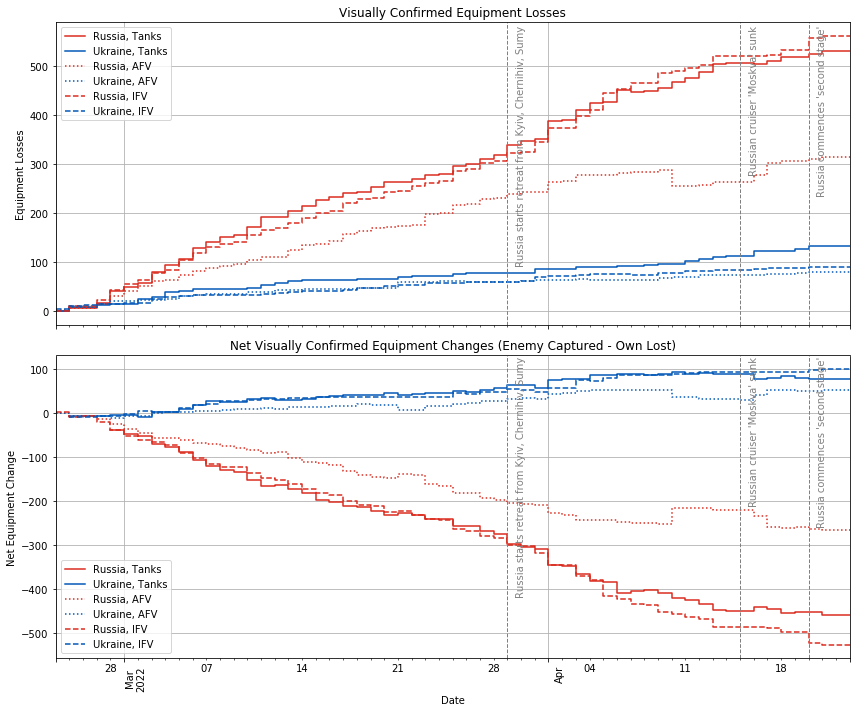

In [122]:
from matplotlib import pyplot as plt
from sklearn.linear_model import Lasso
import numpy as np
from matplotlib.patches import Ellipse

data3 = data2.copy()
#m = data2.columns.get_level_values(0) == "Ukraine"
#data2.values[:, m] = data2.values[:, m] * 2
#display(data2)

cc = ["#DA291C", "#0057b7"]

def linreg(vals, fr, to):
    dt = vals.loc[fr:to].resample("1H").max().ffill()
    l = Lasso(positive=True, fit_intercept=True)
    xx = np.arange(dt.shape[0]).reshape((-1, 1))
    
    l.fit(xx, dt.values)
    yh = pd.DataFrame(l.predict(xx), index=dt.index, columns=dt.columns)
    return yh
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,10), sharex=True)
ax = axes[0]
tanks = data3.xs("tanks", axis=1, level=1).groupby(level=0,axis=1).sum().add_suffix(", Tanks")
tanks.plot(grid=True, ax=ax, color=cc, drawstyle="steps")
data3.xs("armouredfightingvehicles", axis=1, level=1).groupby(level=0,axis=1).sum().add_suffix(", AFV").plot(grid=True, ax=ax, color=cc, ls=":", drawstyle="steps")
data3.xs("infantryfightingvehicles", axis=1, level=1).groupby(level=0,axis=1).sum().add_suffix(", IFV").plot(grid=True, ax=ax, color=cc, ls="--", drawstyle="steps")
#data3.xs("trucksvehiclesandjeeps", axis=1, level=1).groupby(level=0,axis=1).sum().add_suffix(", Trucks").plot(grid=True, ax=ax, color=cc, ls="-.")
# linreg(tanks, "2022-02-28", None).plot(grid=True, ax=ax, color="gray", ls="-")
#linreg(tanks, "2022-03-07", "2022-03-12").plot(grid=True, ax=ax, color="gray", ls="-")

ax.set_title("Visually Confirmed Equipment Losses")
ax.set_xlabel("Date")
ax.set_ylabel("Equipment Losses")

def get_incl_captured(key):
    raw = data3.xs(key, axis=1, level=1).groupby(level=0,axis=1).sum()
    capt = data3.xs(key, axis=1, level=1).xs("captured", axis=1, level=1)
    capt.columns = capt.columns[::-1]
    ab = data3.xs(key, axis=1, level=1).xs("abandoned", axis=1, level=1)
    ab.columns = ab.columns[::-1]
    return capt - raw
# ax.text(x="2022-04-10",y=300, s="Some AFV removed and re-added,\nas origin not confirmed", color=cc[0])
# circ = Ellipse(("2022-04-10", 290), 2/3, 55/3, color=cc[0],alpha=0.2)
# ax.add_patch(circ)

ax = axes[1]
get_incl_captured("tanks").add_suffix(", Tanks").plot(grid=True, ax=ax, color=cc, drawstyle="steps")
get_incl_captured("armouredfightingvehicles").add_suffix(", AFV").plot(grid=True, ax=ax, color=cc, ls=":", drawstyle="steps")
get_incl_captured("infantryfightingvehicles").add_suffix(", IFV").plot(grid=True, ax=ax, color=cc, ls="--", drawstyle="steps")
#get_incl_captured("trucksvehiclesandjeeps").add_suffix(", IFV").plot(grid=True, ax=ax, color=cc, ls="-.")
ax.set_title("Net Visually Confirmed Equipment Changes (Enemy Captured - Own Lost)")
ax.set_xlabel("Date")
ax.set_ylabel("Net Equipment Change")
import matplotlib.dates as mdates


def hl_text(x, s, ax):
    ym = ax.get_ylim()[1] * 0.99
    ax.text(x=pd.to_datetime(x) + pd.offsets.Day(1),y=ym, s=s, rotation=90, va="top", ha="center", color="gray")
    ax.axvline(x=x, ls="--", lw=1, color="gray")

for a in axes:
    hl_text("2022-03-29","Russia starts retreat from Kyiv, Chernihiv, Sumy", a)
    hl_text("2022-04-15","Russian cruiser 'Moskva' sunk", a)
    hl_text("2022-04-20","Russia commences 'second stage'", a)

#ax.xaxis.set_major_locator(mdates.AutoDateLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter("%d. %b"))
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig("losses.png")